In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df = pd.read_csv(
    './data/Estimar_UH2021.txt', engine='python', sep='|',
    parse_dates=[0],
    dayfirst=True,
    decimal=','
)

## Forwardfill product price and drop any missing values from the front

`ffill` in pandas rolls the values forward. This is described as the correct method by the organizer to fill the missing price values.

In [ ]:
from IPython.display import clear_output

df_fill = df.copy()

total = len(df.id.unique())

for i, pid in enumerate(df.id.unique()):
    # This product's entries
    df_prod = df[df.id == pid]
    
    # Fillforward, then back to cover the first few lines
    df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

    # Save to DF
    df_fill.loc[df_prod.index] = df_prod
    
    clear_output(wait=True)
    print("Filled %.1f%% of the Dataframe" % (i/total * 100))

df_fill.to_csv('./data/Estimar_UH2021_filled_precio.txt')

## Use this DF from here on with the filled Price

In [2]:
df = pd.read_csv(
    './data/Modelar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)
# Adjust years
df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)

In [3]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)
df[:5]

(4045022, 11)
(2038556, 11)


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2018-06-01,21972,0,C,75.0,No Rotura,5.84,0,0,5241.0,0
1,2018-06-01,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,2018-06-01,24306,13,A,46.0,No Rotura,7.85,0,0,NaN,0
4,2018-06-01,27144,15,E,230.0,No Rotura,6.12,0,0,4064.0,0
5,2018-06-01,27504,7,C,157.0,No Rotura,10.74,0,0,5261.0,0


# Feature Engineering and data cleaning

In [4]:
df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')

df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
df['estado_transito'] = (df.estado == 'Transito').astype(int)
df['estado_rotura'] = (df.estado == 'Rotura').astype(int)

df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')

df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)

df_fe = df_fe.drop(['estado', 'dia_atipico'], axis=1, errors='ignore')

print(df_fe.shape)
df_fe[:5]

(2038556, 187)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,...,categoria_dos__86,categoria_dos__89,categoria_dos__9,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__96,categoria_dos__97,categoria_dos__98,categoria_dos__nan
0,2018-06-01,21972,0,C,75,5.84,0,5241.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-06-01,23910,5,C,1,6.07,0,5241.0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-06-01,24306,13,A,46,7.85,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-06-01,27144,15,E,2,6.12,0,4064.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2018-06-01,27504,7,C,157,10.74,0,5261.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DO NOT USE - Onehot encoding of Months 

In [9]:
# df_weekday_onehot = pd.get_dummies(df_fe.fecha.dt.weekday, prefix='fecha_weekday_')
# df_month_onehot = pd.get_dummies(df_fe.fecha.dt.month, prefix='fecha_month_')

# df_fe = pd.concat([df_fe, df_weekday_onehot, df_month_onehot], axis=1)

# df_fe

## Inspect `antiguedad`

0.9995797283622673


<AxesSubplot:xlabel='fecha'>

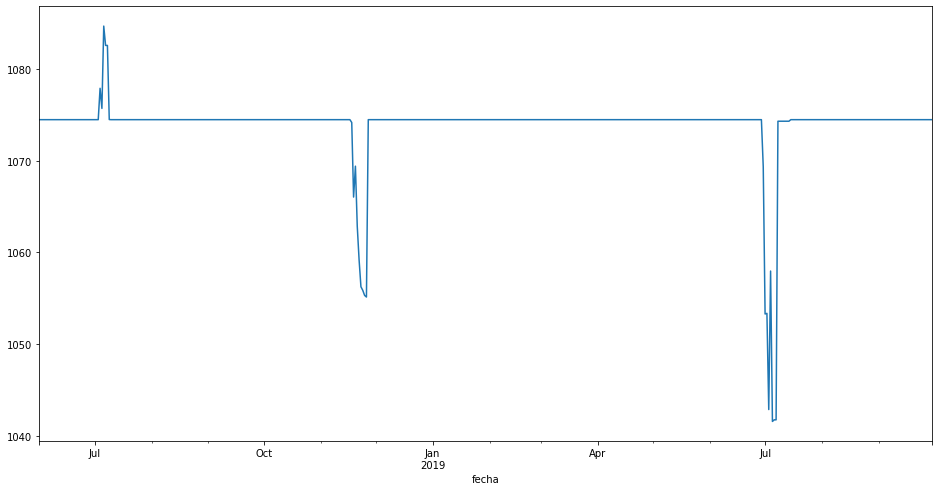

In [16]:
pre = df_fe.fecha <= datetime(2019,1,24)
post = df_fe.fecha > datetime(2019,1,24)

pre_stats = df_fe[pre].describe().antiguedad
post_stats = df_fe[post].describe().antiguedad

# Candidate for scaling, but we end up using StandardScaler on the two intervals instead
scale_f = post_stats['mean'] / pre_stats['mean']
print(scale_f)

plt.figure(figsize=[16,8])
df_fe.groupby('fecha').mean().antiguedad.plot()

## Rescale of `visitas` from 2016-01-24 backwards

In [5]:
pre = df_fe.fecha <= datetime(2019,1,24)
post = df_fe.fecha > datetime(2019,1,24)

pre_stats = df_fe[pre].describe().visitas
post_stats = df_fe[post].describe().visitas

# Candidate for scaling, but we end up using StandardScaler on the two intervals instead
scale_f = post_stats['mean'] / pre_stats['mean']
scale_f

4.105763544999672

In [22]:
# Final confirmation that something is going on, these data were preprocessed
pre_stats['max'], post_stats['max']

(92385.0, 120045.0)

In [6]:
from sklearn.preprocessing import StandardScaler

pre_scl = StandardScaler().fit_transform(df_fe[pre][['visitas']])[:,0]
post_scl = StandardScaler().fit_transform(df_fe[post][['visitas']])[:,0]

df_fe['visitas_scl'] = np.concatenate([
    df_fe[pre].visitas * 5,
    df_fe[post].visitas * 1,
    #     StandardScaler().fit_transform(df_fe[pre][['visitas']])[:,0],
    #     StandardScaler().fit_transform(df_fe[post][['visitas']])[:,0],
    ], axis=0
)

<AxesSubplot:xlabel='fecha'>

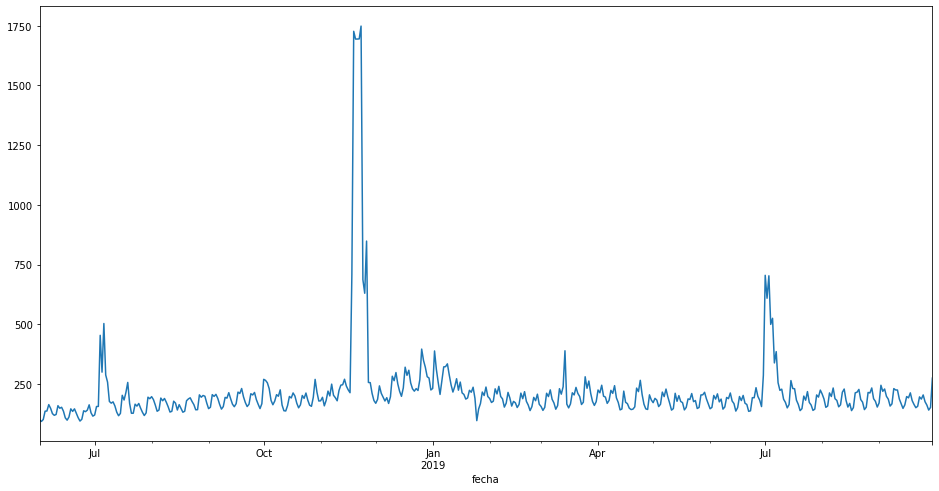

In [7]:
plt.figure(figsize=[16,8])
df_fe.groupby('fecha').mean().visitas_scl.plot()
# df_fe.groupby('fecha').mean().visitas.plot()

## Adjustment of `weekday` from 2016-01-24 backwards 

Not needed since we adjusted the years correctly

Text(0.5, 1.0, 'Unidades Vendidas')

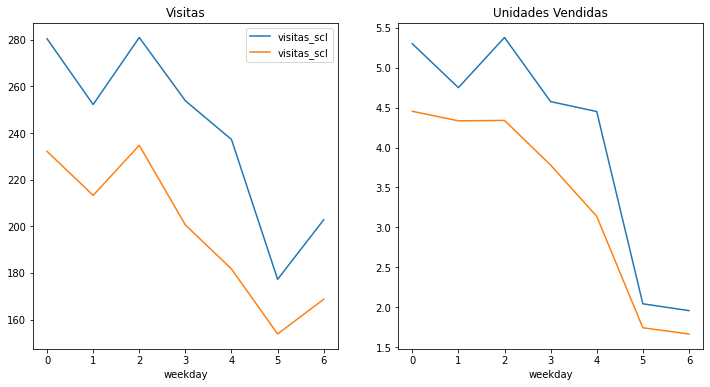

In [9]:
# pre = df_fe.fecha <= datetime(2016,1,24)
# post = df_fe.fecha > datetime(2016,1,24)

df_fe['weekday'] = df_fe.fecha.dt.weekday

# df_fe['weekday_off'] = np.concatenate([
#     (df_fe[pre]['weekday'] + 1) % 7,
#     df_fe[post]['weekday'],
# ], axis=0 )

plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
df_fe[pre].groupby('weekday').mean().visitas_scl.plot()
df_fe[post].groupby('weekday').mean().visitas_scl.plot()
plt.title('Visitas')

plt.subplot(1,2,2)
df_fe[pre].groupby('weekday').mean().unidades_vendidas.plot()
df_fe[post].groupby('weekday').mean().unidades_vendidas.plot()
plt.title('Unidades Vendidas')

## Sin-Cos transform of Month / Weekday

In [10]:
df_fe['weekday_sin'] = np.sin(df_fe.weekday * (2*np.pi/7))
df_fe['weekday_cos'] = np.cos(df_fe.weekday * (2*np.pi/7))

# df_fe['month_sin'] = np.sin((df.fecha.dt.month-1) * (2*np.pi/12))
# df_fe['month_cos'] = np.cos((df.fecha.dt.month-1) * (2*np.pi/12))

month_con = df_fe["fecha"].dt.month + (df_fe["fecha"].dt.day / df_fe["fecha"].dt.days_in_month)

df_fe['month_sin'] = np.sin((month_con-1) * (2*np.pi/12))
df_fe['month_cos'] = np.cos((month_con-1) * (2*np.pi/12))


# del df_fe['fecha']
df_fe

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,...,categoria_dos__96,categoria_dos__97,categoria_dos__98,categoria_dos__nan,visitas_scl,weekday,weekday_sin,weekday_cos,month_sin,month_cos
0,2018-06-01,21972,0,C,75,5.84,0,5241.0,0,0,...,0,0,0,0,0,4,-0.433884,-0.900969,0.48481,-8.746197e-01
1,2018-06-01,23910,5,C,1,6.07,0,5241.0,3,0,...,0,0,0,0,25,4,-0.433884,-0.900969,0.48481,-8.746197e-01
2,2018-06-01,24306,13,A,46,7.85,0,NaN,0,0,...,0,0,0,0,65,4,-0.433884,-0.900969,0.48481,-8.746197e-01
4,2018-06-01,27144,15,E,2,6.12,0,4064.0,0,0,...,0,0,0,0,75,4,-0.433884,-0.900969,0.48481,-8.746197e-01
5,2018-06-01,27504,7,C,157,10.74,0,5261.0,0,0,...,0,0,0,0,35,4,-0.433884,-0.900969,0.48481,-8.746197e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045016,2019-09-30,456982,6575,F,336,81.28,0,NaN,30,0,...,0,0,0,0,6575,0,0.000000,1.000000,-1.00000,-1.836970e-16
4045017,2019-09-30,457416,1395,F,336,50.38,0,130.0,9,0,...,0,0,0,0,1395,0,0.000000,1.000000,-1.00000,-1.836970e-16
4045018,2019-09-30,457422,1080,F,336,93.77,0,130.0,0,0,...,0,0,0,0,1080,0,0.000000,1.000000,-1.00000,-1.836970e-16
4045019,2019-09-30,458650,1385,K,3,70.85,0,126.0,0,0,...,0,0,0,0,1385,0,0.000000,1.000000,-1.00000,-1.836970e-16


## Data Quality (NANs etc)

In [11]:
# df_fe = df_fe.drop(["antiguedad"], axis=1, errors='ignore')

print(df_fe.shape)
df_fe_no_nans = df_fe.dropna(how='any', inplace=False)
print(df_fe_no_nans.shape)
df_fe_no_nans[:5]

(2038556, 193)
(1559222, 193)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,...,categoria_dos__96,categoria_dos__97,categoria_dos__98,categoria_dos__nan,visitas_scl,weekday,weekday_sin,weekday_cos,month_sin,month_cos
0,2018-06-01,21972,0,C,75,5.84,0,5241.0,0,0,...,0,0,0,0,0,4,-0.433884,-0.900969,0.48481,-0.87462
1,2018-06-01,23910,5,C,1,6.07,0,5241.0,3,0,...,0,0,0,0,25,4,-0.433884,-0.900969,0.48481,-0.87462
4,2018-06-01,27144,15,E,2,6.12,0,4064.0,0,0,...,0,0,0,0,75,4,-0.433884,-0.900969,0.48481,-0.87462
5,2018-06-01,27504,7,C,157,10.74,0,5261.0,0,0,...,0,0,0,0,35,4,-0.433884,-0.900969,0.48481,-0.87462
6,2018-06-01,30014,5,C,63,6.12,0,2954.0,3,0,...,0,0,0,0,25,4,-0.433884,-0.900969,0.48481,-0.87462


### Save final cleaned data

In [12]:
df_fe_no_nans.to_csv('data/Modelar_UH2021_clean.txt', index=False)

## Visualize time series for Sold units (Target)

Grouped by date.

<AxesSubplot:xlabel='fecha'>

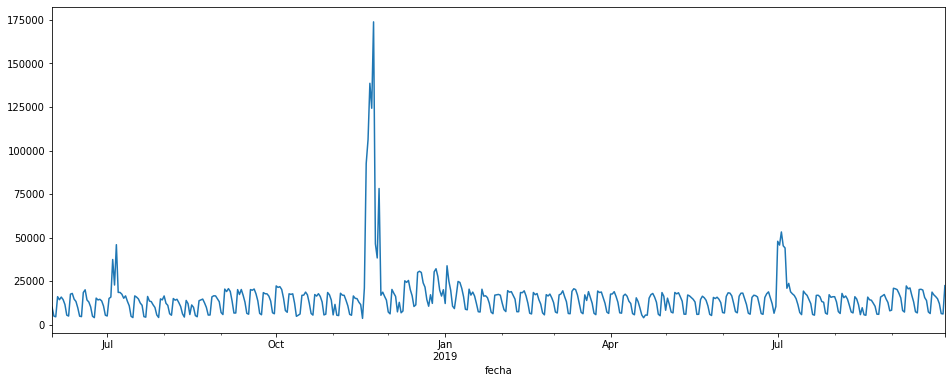

In [38]:
plt.figure(figsize=[16,6])

data = df_fe.groupby('fecha').sum().sort_values('fecha')
data.unidades_vendidas.plot()

## Distribution of the Target Variable

- Unbalanced data set (so many lines are of value 0)
- Long tail of numbers, follows zipf distribution more or less, where nth number is proportional to 1/n

<AxesSubplot:xlabel='unidades_vendidas', ylabel='Count'>

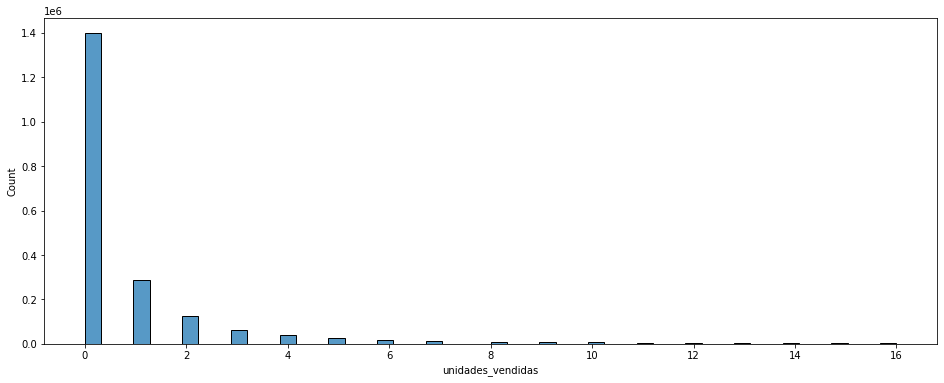

In [39]:
plt.figure(figsize=[16,6])

data = df_fe.unidades_vendidas[df_fe.unidades_vendidas < 50]

sns.histplot(data // 3, bins=50)

## Single product target variable Plot

<AxesSubplot:xlabel='fecha,id'>

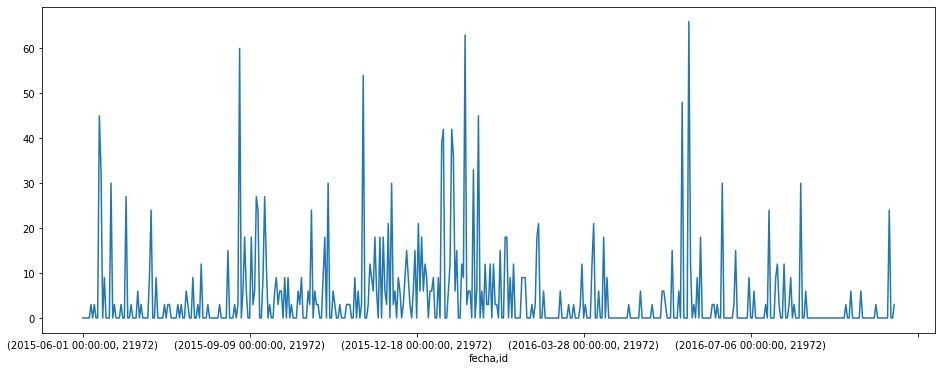

In [56]:
plt.figure(figsize=[16,6])

data = df_fe[['fecha', 'id', 'unidades_vendidas']]
data = data.groupby(['fecha','id']).sum()

pid = 21972
data.loc[(slice(None), slice(pid)), :].unidades_vendidas.plot()

## Pairplot

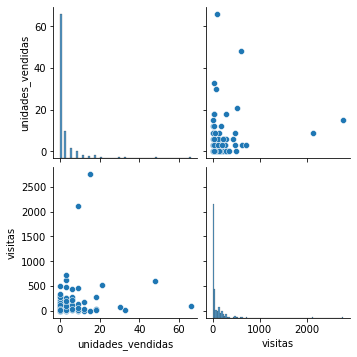

In [59]:
sns.pairplot(df_fe[['unidades_vendidas','visitas', '']][::10000])

## Autogluon

In [12]:
import autogluon.core as ag
from autogluon import TabularPrediction as task

In [162]:
df=df_fe
df=df.drop(["fecha","id","antiguedad"],axis=1)

In [163]:
import random
np.random.seed(20)
msk = np.random.rand(len(df)) < 0.9

train = df[msk]

test = df[~msk]

In [164]:
train_data = task.Dataset(train)
test_data = task.Dataset(test)
subsample_size = 1000000  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=20)
train_data

,visitas,categoria_uno,precio,campaña,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura,weekday_sin,weekday_cos,month_sin,month_cos
26395,10,G,21.17,0,6,0,1,0,1,0,0,0.433884,-0.900969,0.438371,-0.898794
4029757,55,A,37.70,0,0,0,1,0,1,0,0,0.433884,-0.900969,-0.999848,-0.017452
1030587,54,A,37.41,0,0,0,1,0,1,0,0,-0.974928,-0.222521,-0.998717,0.050649
3674701,120,A,31.72,0,3,0,1,0,1,0,0,0.974928,-0.222521,-0.724793,-0.688967
2105415,0,H,54.25,0,0,0,1,0,1,0,0,0.781831,0.623490,0.633521,0.773726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449084,90,A,11.86,0,0,0,1,0,1,0,0,0.433884,-0.900969,-0.347305,-0.937752
362221,56,K,81.63,0,0,0,1,0,0,0,1,0.781831,0.623490,-0.234266,-0.972172
388062,18,A,32.94,0,0,0,1,0,0,0,1,-0.433884,-0.900969,-0.283206,-0.959059
906108,25,C,6.12,0,12,0,1,0,1,0,0,-0.433884,-0.900969,-0.978148,-0.207912


In [166]:
directory=r"D:\test"
time_limits = 3600 # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
presets="medium_quality_faster_train" # roduces less accurate models but facilitates faster prototyping
predictor = task.fit(train_data=train_data,
                     output_directory=directory,
                     label="unidades_vendidas", 
                     time_limits=time_limits,
                     presets=presets,
                     eval_metric="root_mean_squared_error",
                    problem_type="regression")

Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to D:\test\
AutoGluon Version:  0.0.14
Train Data Rows:    1000000
Train Data Columns: 14
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24516.81 MB
	Train Data (Original)  Memory Usage: 146.0 MB (0.6% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 5 | ['precio', 'weekday_sin', 'weekday_cos',

In [167]:
predictor.leaderboard(test_data,silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestRegressorMSE,-10.914847,-12.471817,6.782829,0.237998,211.846033,6.782829,0.237998,211.846033,0,True,1
1,weighted_ensemble_k0_l1,-11.338878,-11.364404,25.749454,1.140599,2074.099889,0.347044,0.000000,0.711576,1,True,10
2,LightGBMRegressorCustom,-11.440851,-12.680820,0.379144,0.034038,4.205760,0.379144,0.034038,4.205760,0,True,9
3,LightGBMRegressor,-11.783164,-12.054869,0.159997,0.024060,3.541277,0.159997,0.024060,3.541277,0,True,5
4,CatboostRegressor,-11.959262,-11.988569,0.063696,0.022003,30.733324,0.063696,0.022003,30.733324,0,True,7
5,ExtraTreesRegressorMSE,-12.132205,-12.383112,6.273131,0.120000,120.367204,6.273131,0.120000,120.367204,0,True,2
6,NeuralNetRegressor,-12.320153,-12.270896,9.883268,0.531077,1640.068605,9.883268,0.531077,1640.068605,0,True,8
7,LightGBMRegressorXT,-13.016653,-13.020732,0.152003,0.020001,2.888589,0.152003,0.020001,2.888589,0,True,6
8,KNeighborsRegressorDist,-14.875369,-15.994317,2.699934,0.222116,67.587286,2.699934,0.222116,67.587286,0,True,4
9,KNeighborsRegressorUnif,-15.589846,-19.477230,2.399485,0.229521,70.373147,2.399485,0.229521,70.373147,0,True,3


In [188]:
def myround(x, base=3):
    return base * np.round_(x/base)

In [189]:
yhat=predictor.predict(test_data)
yhat_rounded=myround(yhat)

In [191]:
from sklearn.metrics import mean_squared_error as mse

print(mse(test_data.unidades_vendidas, yhat))
print(mse(test_data.unidades_vendidas, yhat_rounded))

128.59638704544116
129.17048776886352


In [170]:
test_f = df_fe[~msk]
test_f["prediction"]=yhat

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
test_f

,fecha,id,visitas,categoria_uno,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura,weekday_sin,weekday_cos,month_sin,month_cos,prediction
27,2015-06-01,56310,11,C,10.17,0,4355.0,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,4.624325
93,2015-06-01,80454,29,A,24.21,0,NaN,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,1.194967
116,2015-06-01,85388,33,G,17.20,0,3246.0,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,3.281117
145,2015-06-01,86924,6,C,8.79,0,3195.0,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,2.651236
188,2015-06-01,92324,9,C,10.76,0,3011.0,3,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,2.049594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044987,2016-09-30,443662,1080,K,47.12,0,166.0,33,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,28.121780
4044992,2016-09-30,445634,17730,F,57.55,0,160.0,153,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,169.465973
4044995,2016-09-30,446500,1230,K,64.29,0,159.0,18,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,21.419184
4045014,2016-09-30,454656,120,K,10.17,0,134.0,42,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,20.438971


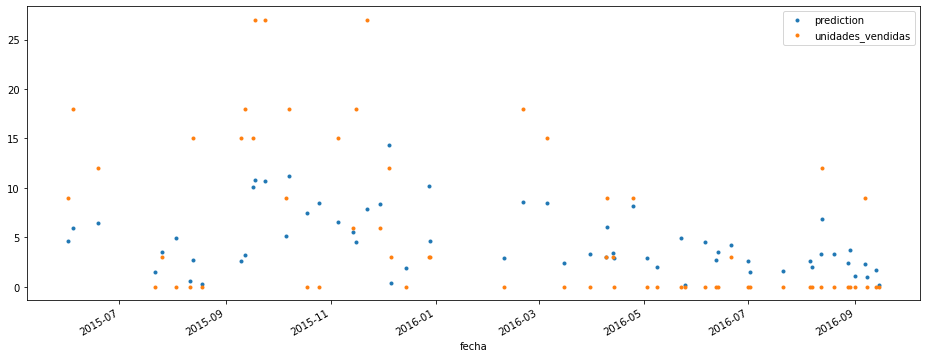

In [194]:
plt.figure(figsize=[16,6])

data = test_f[test_f["id"]==56310].groupby('fecha').mean().sort_values('fecha')
data["prediction"].plot(label="prediction",style=".")

data = test_f[test_f["id"]==56310].groupby('fecha').mean().sort_values('fecha')
data.unidades_vendidas.plot(style=".")
plt.legend()

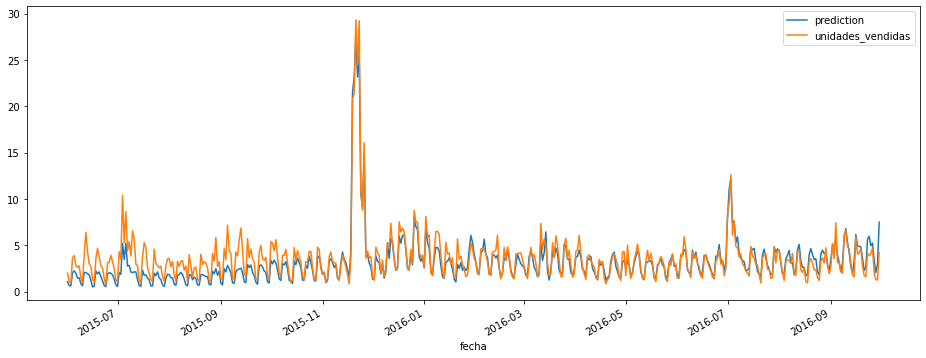

In [196]:
plt.figure(figsize=[16,6])

data = test_f.groupby('fecha').mean().sort_values('fecha')
data["prediction"].plot(label="prediction")

data = test_f.groupby('fecha').mean().sort_values('fecha')
data.unidades_vendidas.plot()
plt.legend()

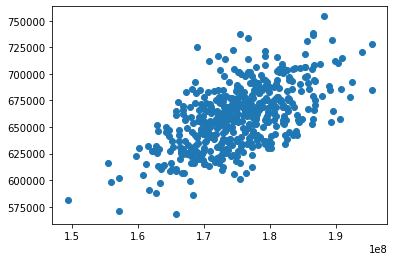

In [123]:
plt.scatter(data["id"],data["antiguedad"])

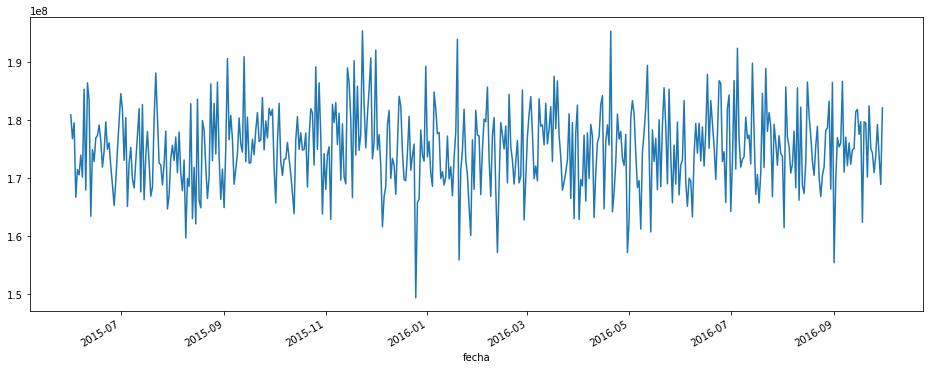

In [120]:
plt.figure(figsize=[16,6])

data = test_f.groupby('fecha').sum().sort_values('fecha')
data.id.plot(label="prediction")

